In [12]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Processing Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Model Selection
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV, StratifiedKFold

# Scikit-learn: Preprocessing
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn: Models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Scikit-learn: Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Scipy distributions for RandomizedSearchCV
from scipy.stats import uniform, randint

In [13]:
# Load the dataset
data = pd.read_csv('../../datasets/creditcard.csv') # change path if you need to

# Initial Exploration
print("Info about the dataset:")
print("-------------------------")
print(data.info())
print("-------------------------")
print("How many missing values are there in each column?")
print("-------------------------")
print(data.isna().sum())
print("-------------------------")
print("How many null values are there in each column?")
print("-------------------------")
print(data.isnull().sum())


Info about the dataset:
-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20

Dataset Shape: (284807, 31)


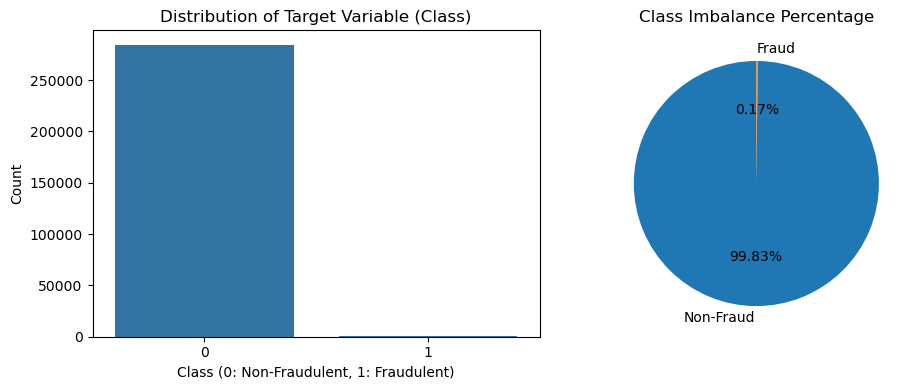


Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Imbalance Ratio: 577.88:1

Statistical Summary of Amount and Time:
                Time         Amount
count  284807.000000  284807.000000
mean    94813.859575      88.349619
std     47488.145955     250.120109
min         0.000000       0.000000
25%     54201.500000       5.600000
50%     84692.000000      22.000000
75%    139320.500000      77.165000
max    172792.000000   25691.160000


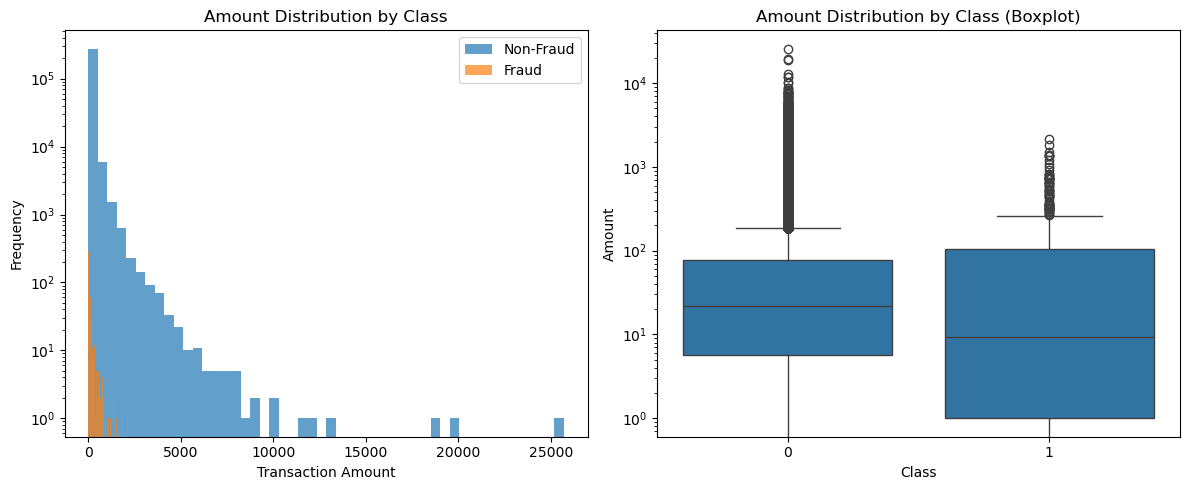

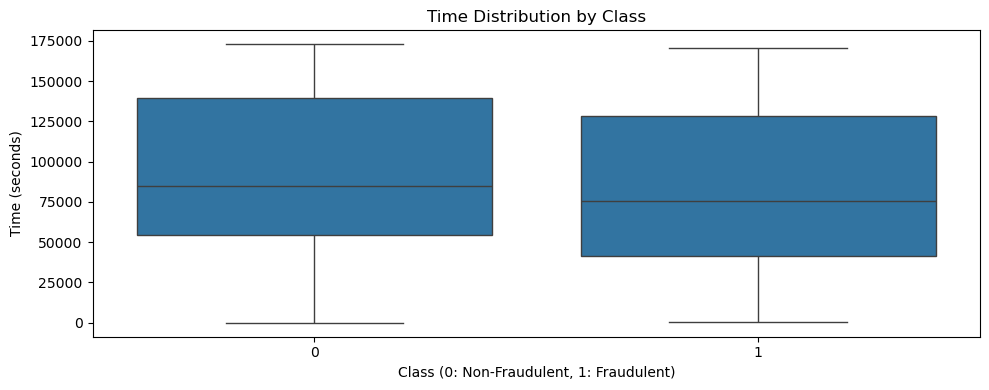


Top 15 Features Correlated with Fraud:
V17   -0.326481
V14   -0.302544
V12   -0.260593
V10   -0.216883
V16   -0.196539
V3    -0.192961
V7    -0.187257
V11    0.154876
V4     0.133447
V18   -0.111485
V1    -0.101347
V9    -0.097733
V5    -0.094974
V2     0.091289
V6    -0.043643
Name: Class, dtype: float64


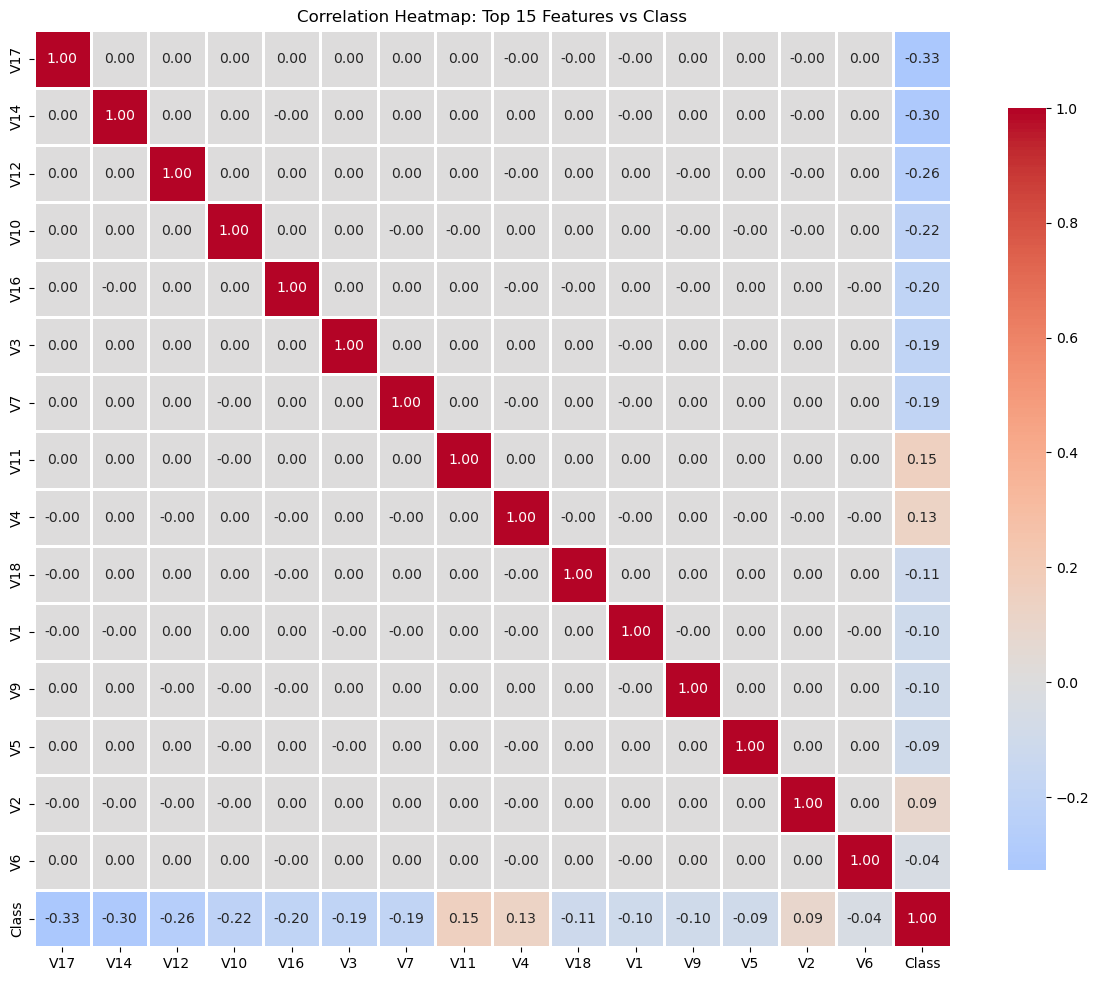

In [14]:
# Exploratory Data Analysis (EDA)

# 1. Dataset Overview
print("Dataset Shape:", data.shape)

# 2. Class Distribution (Imbalance Check)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(x='Class', data=data)
plt.title('Distribution of Target Variable (Class)')
plt.xlabel('Class (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
class_counts = data['Class'].value_counts()
plt.pie(class_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%', startangle=90)
plt.title('Class Imbalance Percentage')

plt.tight_layout()
plt.show()

print(f"\nClass Distribution:\n{class_counts}")
print(f"Imbalance Ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# 3. Statistical Summary
print("\nStatistical Summary of Amount and Time:")
print(data[['Time', 'Amount']].describe())

# 4. Amount Distribution by Class
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data[data['Class']==0]['Amount'], bins=50, alpha=0.7, label='Non-Fraud')
plt.hist(data[data['Class']==1]['Amount'], bins=50, alpha=0.7, label='Fraud')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution by Class')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Amount', data=data)
plt.title('Amount Distribution by Class (Boxplot)')
plt.yscale('log')

plt.tight_layout()
plt.show()

# 5. Time Distribution
plt.figure(figsize=(10, 4))
sns.boxplot(x='Class', y='Time', data=data)
plt.title('Time Distribution by Class')
plt.xlabel('Class (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Time (seconds)')
plt.tight_layout()
plt.show()

# 6. Top 15 Features Correlated with Fraud (Heatmap)
v_features = [col for col in data.columns if col.startswith('V')]
correlations = data[v_features + ['Class']].corr()['Class'].drop('Class').sort_values(key=abs, ascending=False)

print("\nTop 15 Features Correlated with Fraud:")
print(correlations.head(15))

# Create correlation matrix for top 15 features + Class
top_15_features = correlations.head(15).index.tolist()
correlation_matrix = data[top_15_features + ['Class']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Top 15 Features vs Class')
plt.tight_layout()
plt.show()

In [15]:
# Baseline Model Pipeline

# Define features and target
X = data.drop('Class', axis=1)
y = data['Class']

# Use stratified sampling to reduce dataset size while maintaining class distribution

print(f"Original dataset size: {len(X):,} samples")

# Sample 30% of data for faster training (stratified)
X_sampled, _, y_sampled, _ = tts(X, y, train_size=0.3, random_state=42, stratify=y)
print(f"Sampled dataset size: {len(X_sampled):,} samples")
print(f"Original class distribution: {y.value_counts(normalize=True).to_dict()}")
print(f"Sampled class distribution: {y_sampled.value_counts(normalize=True).to_dict()}")

# Split into train and test
X_train, X_test, y_train, y_test = tts(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

print(f"\nTrain set size: {len(X_train):,}")
print(f"Test set size: {len(X_test):,}")

# Preprocessing Pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Define the Models

# Logistic Regression Pipeline
log_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))])

# Random Forest Pipeline
rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(random_state=42))])

# Xtreme Gradient Boosting Pipeline
xb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', xgb.XGBClassifier(random_state=42, n_jobs=1))])

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('logistic', log_clf),
        ('random_forest', rf_clf),
        ('xgboost', xb_clf)
    ],
    voting='soft' # Use 'soft' voting to consider predicted probabilities
)


Original dataset size: 284,807 samples
Sampled dataset size: 85,442 samples
Original class distribution: {0: 0.9982725143693799, 1: 0.001727485630620034}
Sampled class distribution: {0: 0.9982678308092039, 1: 0.0017321691907960957}

Train set size: 68,353
Test set size: 17,089


In [16]:
# Hyperparameter Tuning

# RandomizedSearch parameter grid
param_dist_random = {
    'logistic__classifier__C': uniform(0.1, 5),
    'logistic__classifier__class_weight': ['balanced', {0: 1, 1: 20}],
    'random_forest__classifier__n_estimators': randint(50, 150),
    'random_forest__classifier__class_weight': ['balanced', 'balanced_subsample'],
    'xgboost__classifier__n_estimators': randint(50, 150),
    'xgboost__classifier__max_depth': randint(3, 7),
    'xgboost__classifier__learning_rate': uniform(0.05, 0.2),
    'xgboost__classifier__scale_pos_weight': [25, 50, 75]
}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# RandomizedSearch - broad exploration
random_search = RandomizedSearchCV(
    estimator=voting_clf,
    param_distributions=param_dist_random,
    n_iter=10,
    scoring='recall',
    cv=skf,
    n_jobs=-1,
    random_state=42
)

print("Running RandomizedSearch...")
random_search.fit(X_train, y_train)

best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)
y_proba_random = best_model_random.predict_proba(X_test)[:, 1]

report_random = classification_report(y_test, y_pred_random, output_dict=True)
recall_random = report_random['1']['recall']
f1_random = report_random['1']['f1-score']
precision_random = report_random['1']['precision']

print(f"\nRandomizedSearch Results:")
print(f"Recall: {recall_random:.4f} | F1: {f1_random:.4f} | Precision: {precision_random:.4f}")
print(f"Best params: {random_search.best_params_}")


# BayesianSearch - fine-tuning around RandomizedSearch best params
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

best_params = random_search.best_params_

# Extract best values
best_C = best_params.get('logistic__classifier__C', 1.0)
best_rf_n_est = best_params.get('random_forest__classifier__n_estimators', 100)
best_xgb_n_est = best_params.get('xgboost__classifier__n_estimators', 100)
best_xgb_depth = best_params.get('xgboost__classifier__max_depth', 5)
best_xgb_lr = best_params.get('xgboost__classifier__learning_rate', 0.1)
best_scale_pos = best_params.get('xgboost__classifier__scale_pos_weight', 50)

# Build narrow ranges around best parameters
bayesian_param_dist = {
    'logistic__classifier__C': Real(max(0.01, best_C * 0.5), min(10, best_C * 2), prior='log-uniform'),
    'logistic__classifier__class_weight': Categorical(['balanced']),
    'random_forest__classifier__n_estimators': Integer(max(50, best_rf_n_est - 30), min(200, best_rf_n_est + 30)),
    'random_forest__classifier__class_weight': Categorical(['balanced', 'balanced_subsample']),
    'xgboost__classifier__n_estimators': Integer(max(50, best_xgb_n_est - 30), min(200, best_xgb_n_est + 30)),
    'xgboost__classifier__max_depth': Integer(max(2, best_xgb_depth - 2), min(10, best_xgb_depth + 2)),
    'xgboost__classifier__learning_rate': Real(max(0.01, best_xgb_lr * 0.5), min(0.3, best_xgb_lr * 2), prior='log-uniform'),
    'xgboost__classifier__scale_pos_weight': Integer(max(20, best_scale_pos - 25), min(150, best_scale_pos + 25))
}

bayes_search = BayesSearchCV(
    estimator=voting_clf,
    search_spaces=bayesian_param_dist,
    n_iter=15,
    scoring='recall',
    cv=skf,
    n_jobs=-1,
    random_state=42
)

print("\nRunning Bayesian Optimization...")
bayes_search.fit(X_train, y_train)

best_model_bayes = bayes_search.best_estimator_
y_pred_bayes = best_model_bayes.predict(X_test)
y_proba_bayes = best_model_bayes.predict_proba(X_test)[:, 1]

report_bayes = classification_report(y_test, y_pred_bayes, output_dict=True)
recall_bayes = report_bayes['1']['recall']
f1_bayes = report_bayes['1']['f1-score']
precision_bayes = report_bayes['1']['precision']

# Final Comparison
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"{'Metric':<15} {'Random':<12} {'Bayesian':<12} {'Δ':<10}")
print("-"*50)
print(f"{'Recall':<15} {recall_random:<12.4f} {recall_bayes:<12.4f} {recall_bayes-recall_random:+.4f}")
print(f"{'F1-Score':<15} {f1_random:<12.4f} {f1_bayes:<12.4f} {f1_bayes-f1_random:+.4f}")
print(f"{'Precision':<15} {precision_random:<12.4f} {precision_bayes:<12.4f} {precision_bayes-precision_random:+.4f}")
print("="*50)

print("\nConfusion Matrix (Bayesian):")
print(confusion_matrix(y_test, y_pred_bayes))
print("\nClassification Report (Bayesian):")
print(classification_report(y_test, y_pred_bayes))

Running RandomizedSearch...


/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2


RandomizedSearch Results:
Recall: 0.7667 | F1: 0.8214 | Precision: 0.8846
Best params: {'logistic__classifier__C': 0.3322520635999886, 'logistic__classifier__class_weight': 'balanced', 'random_forest__classifier__class_weight': 'balanced', 'random_forest__classifier__n_estimators': 70, 'xgboost__classifier__learning_rate': 0.1400998503939086, 'xgboost__classifier__max_depth': 4, 'xgboost__classifier__n_estimators': 53, 'xgboost__classifier__scale_pos_weight': 25}

Running Bayesian Optimization...

FINAL RESULTS
Metric          Random       Bayesian     Δ         
--------------------------------------------------
Recall          0.7667       0.8333       +0.0667
F1-Score        0.8214       0.8333       +0.0119
Precision       0.8846       0.8333       -0.0513

Confusion Matrix (Bayesian):
[[17054     5]
 [    5    25]]

Classification Report (Bayesian):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17059
           1       0.83

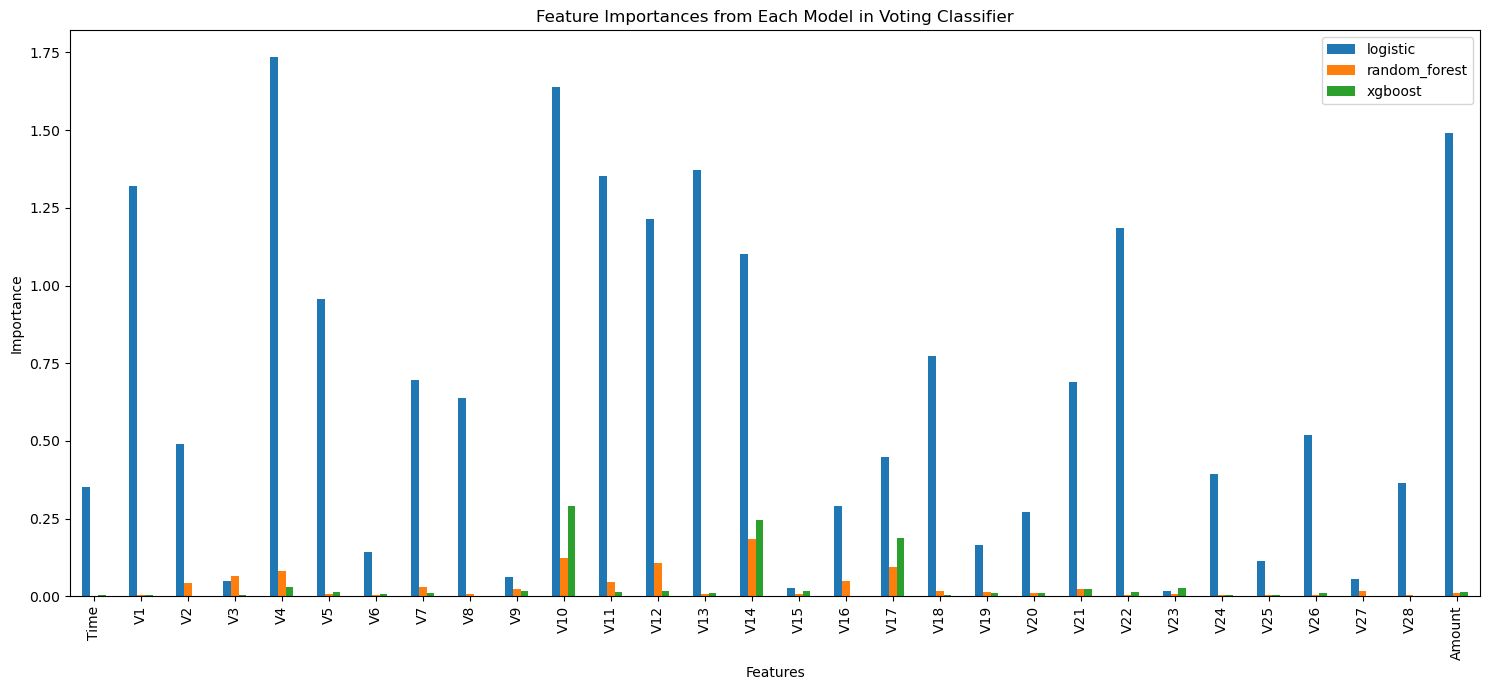

In [17]:
# Feature Importance Analysis for  Voting Classifier

# Extract feature importances from each model in the Voting Classifier
def get_feature_importances(voting_clf, feature_names):
    importances = {}
    
    for name, estimator in voting_clf.named_estimators_.items():
        if hasattr(estimator.named_steps['classifier'], 'feature_importances_'):
            importances[name] = estimator.named_steps['classifier'].feature_importances_
        elif hasattr(estimator.named_steps['classifier'], 'coef_'):
            importances[name] = np.abs(estimator.named_steps['classifier'].coef_).flatten()
    
    # Create a DataFrame to hold importances
    importance_df = pd.DataFrame(importances, index=feature_names)
    return importance_df

feature_names = X.columns.tolist()
importance_df = get_feature_importances(best_model_bayes, feature_names)

# Plot feature importances
importance_df.plot(kind='bar', figsize=(15, 7))
plt.title('Feature Importances from Each Model in Voting Classifier')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Error Analysis - Misclassified Samples:


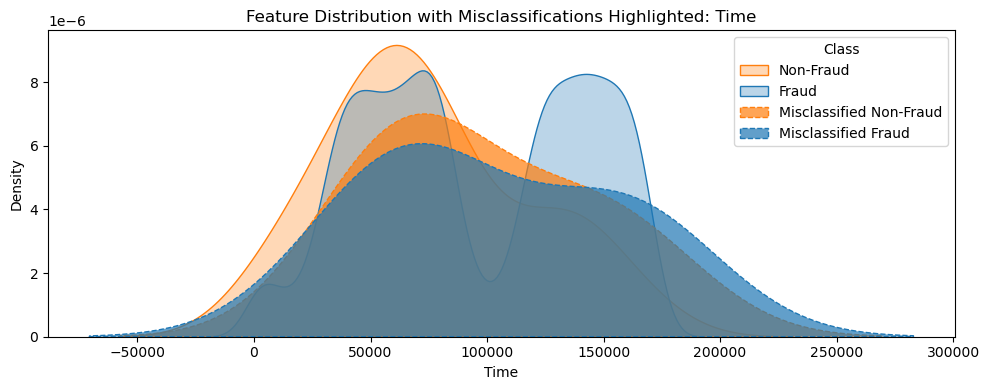

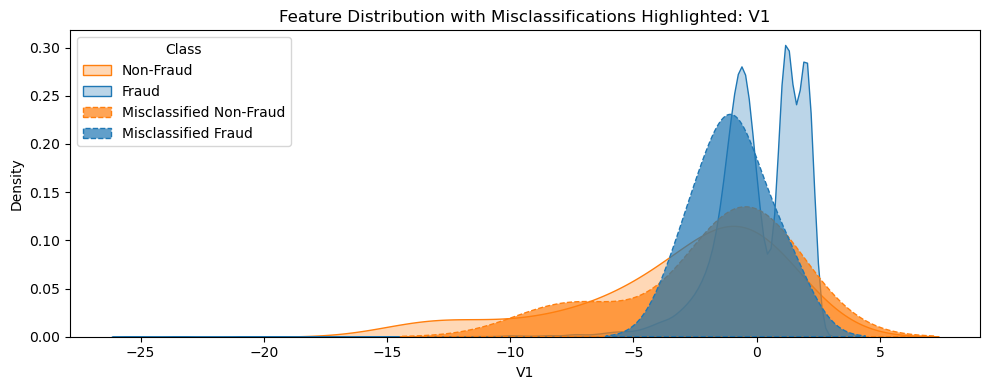

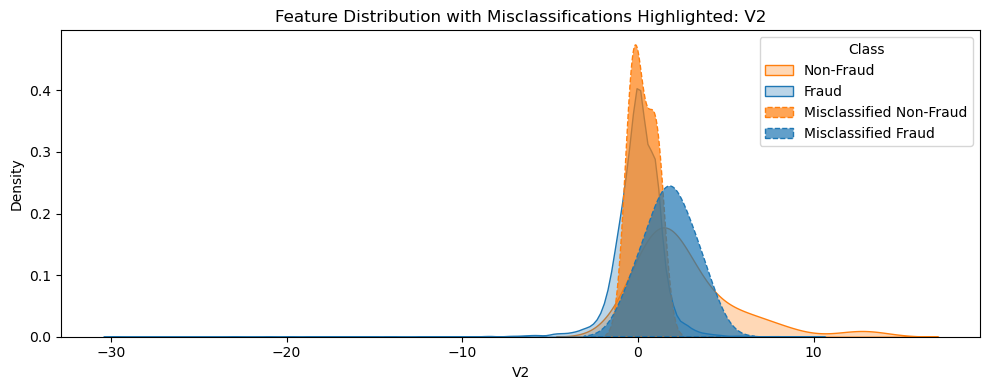

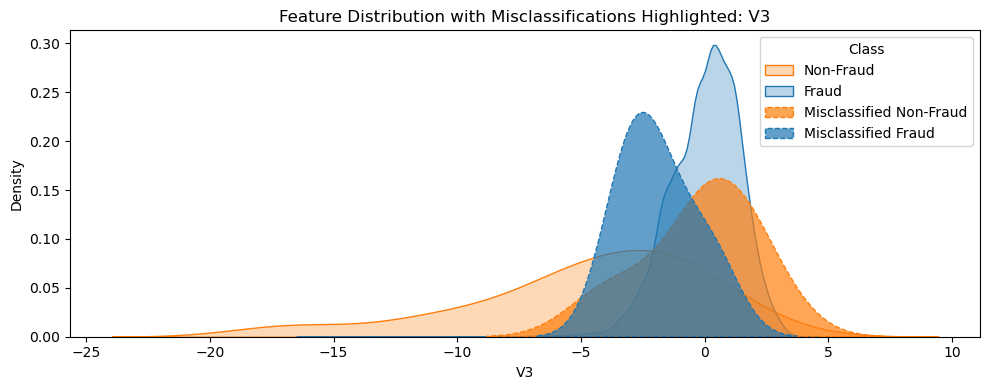

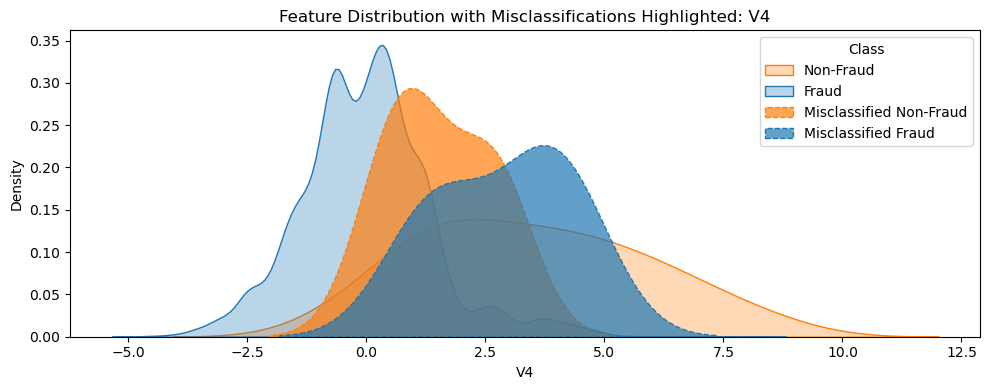

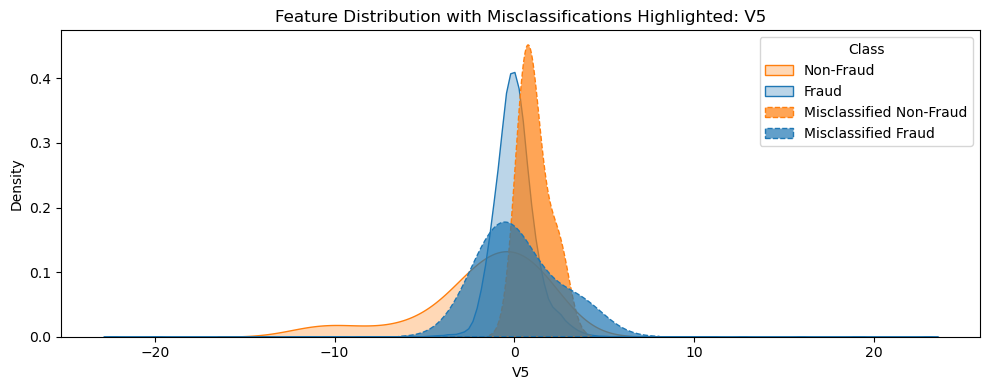

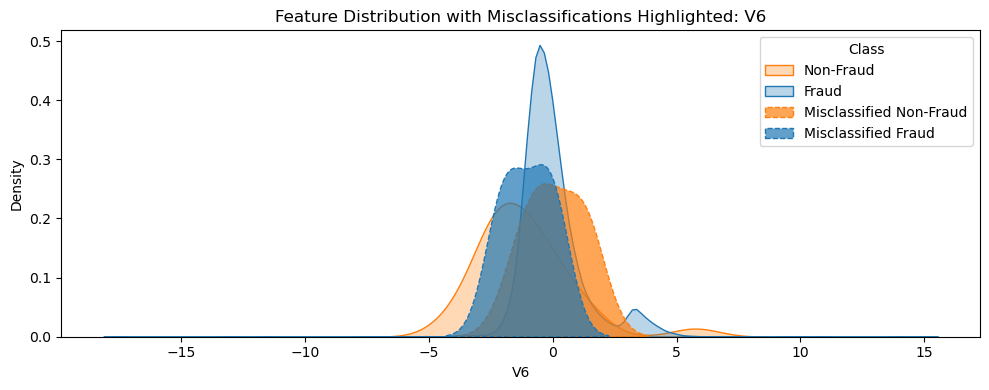

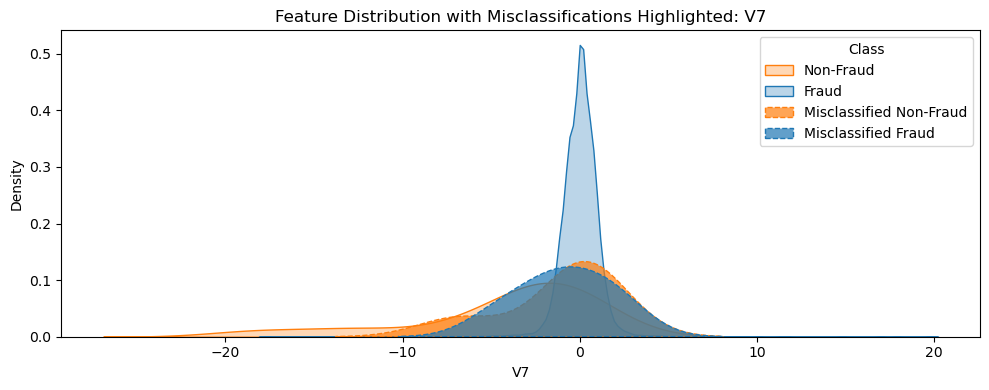

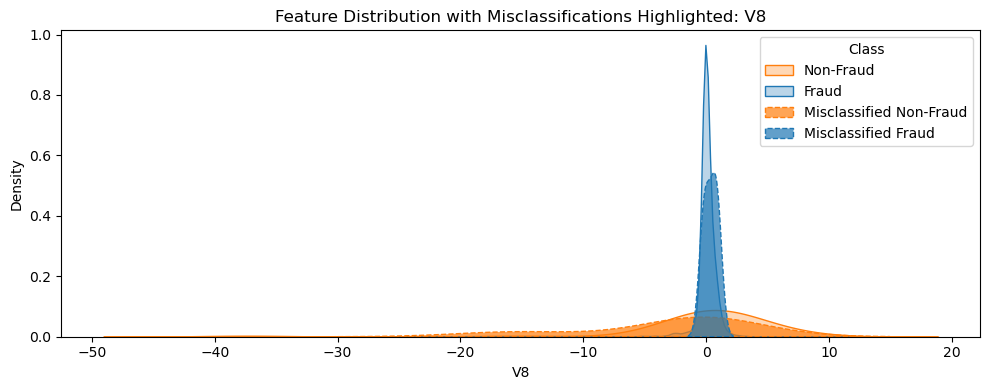

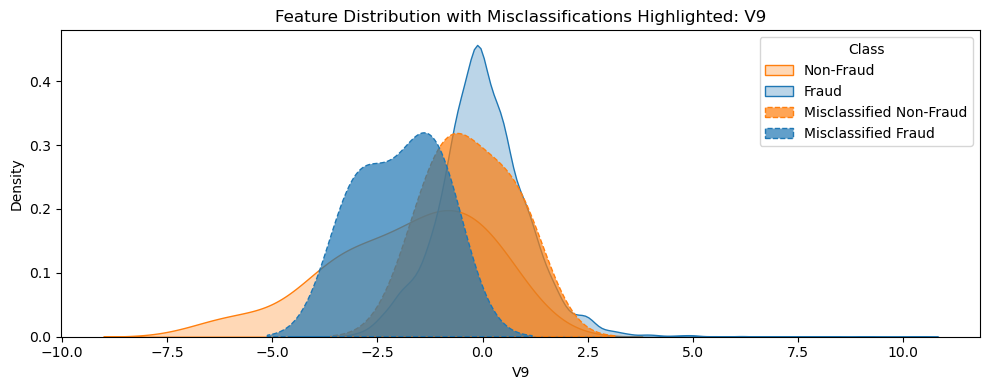

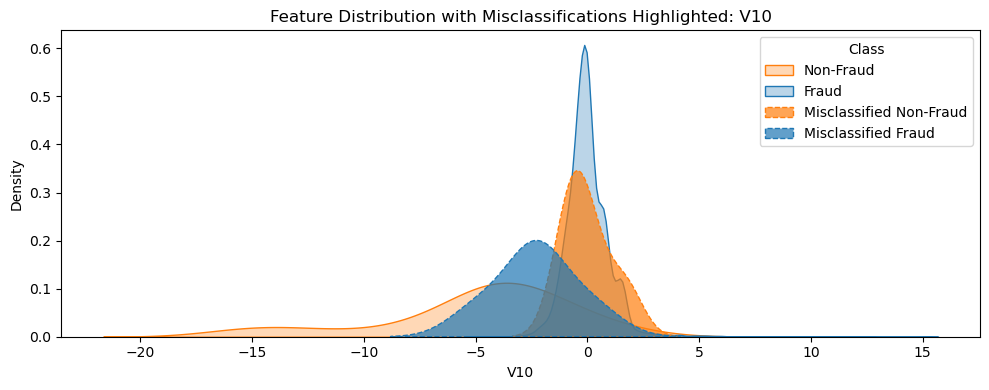

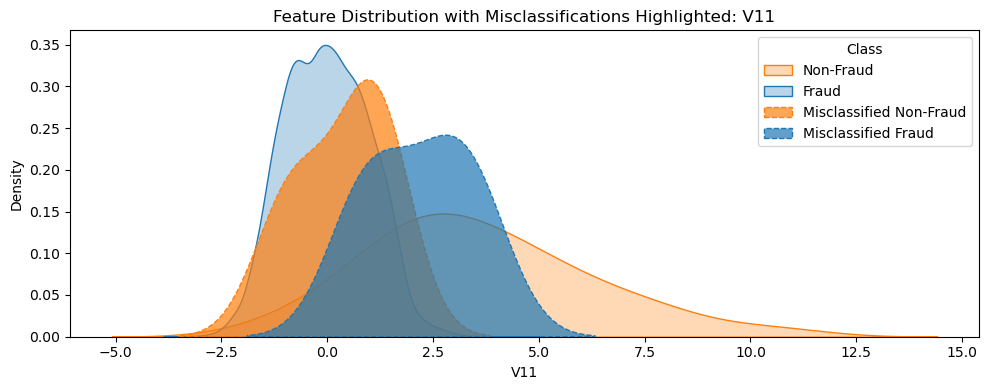

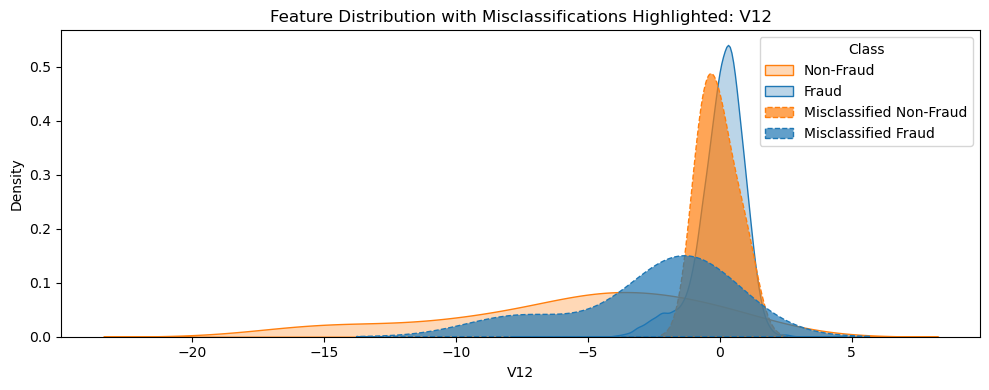

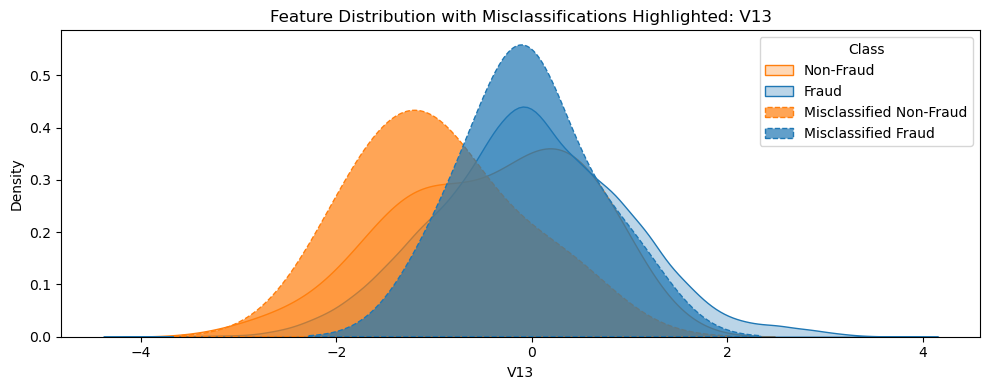

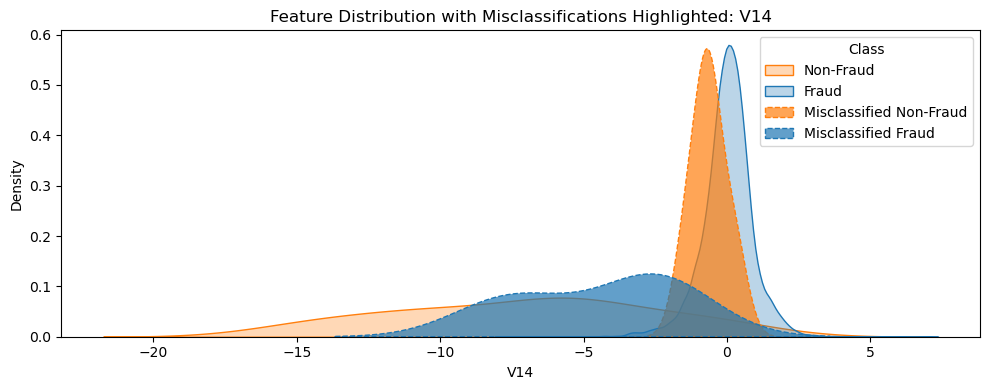

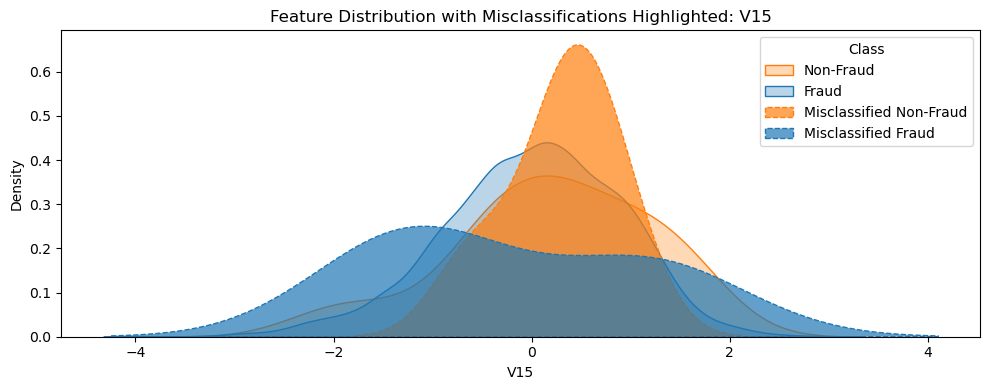

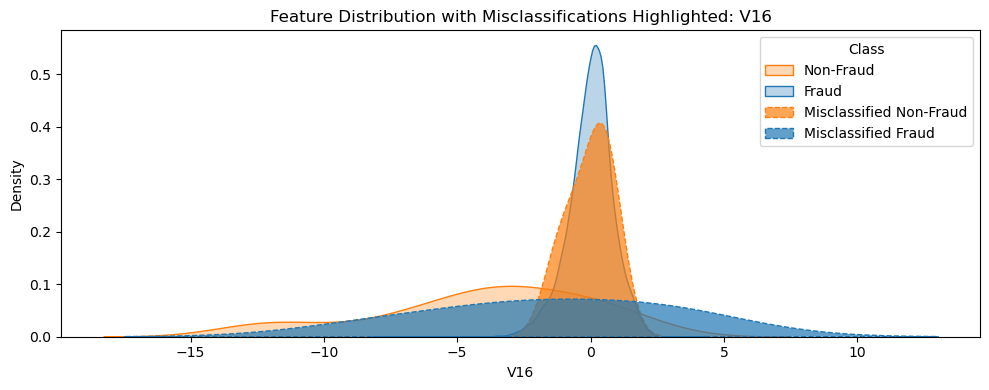

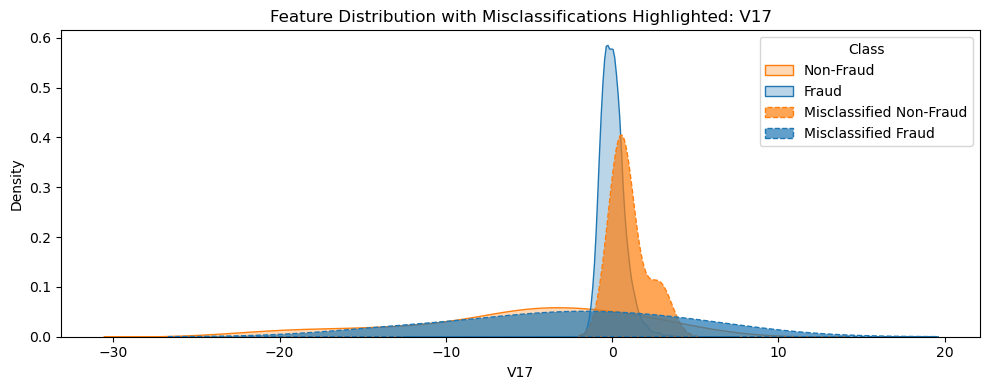

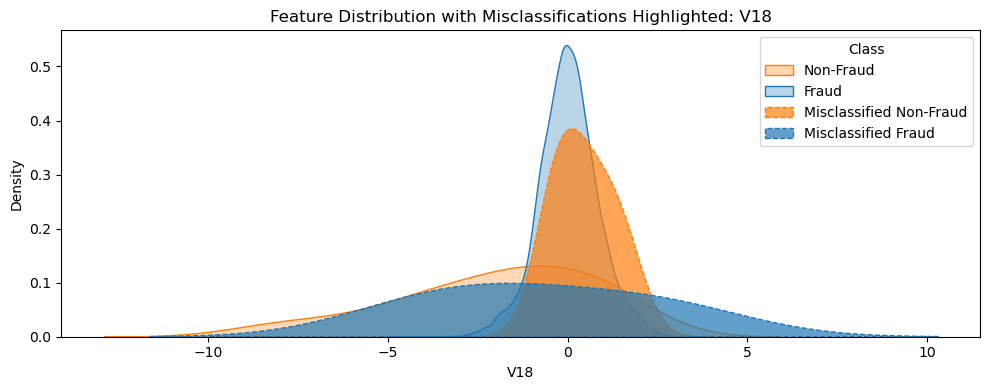

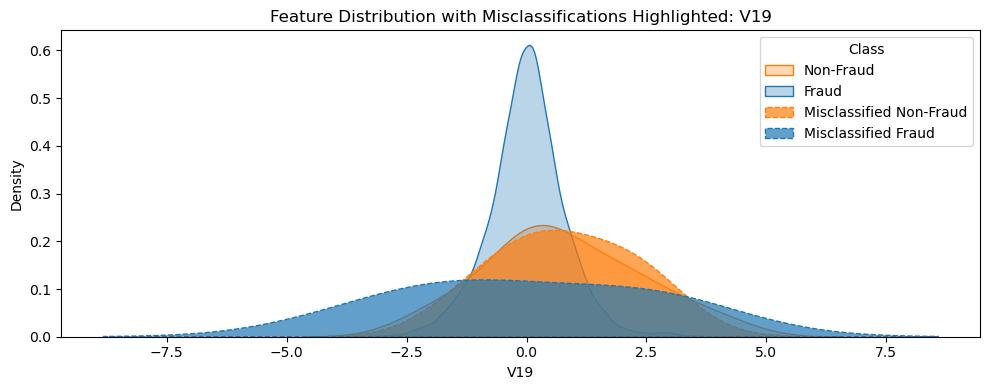

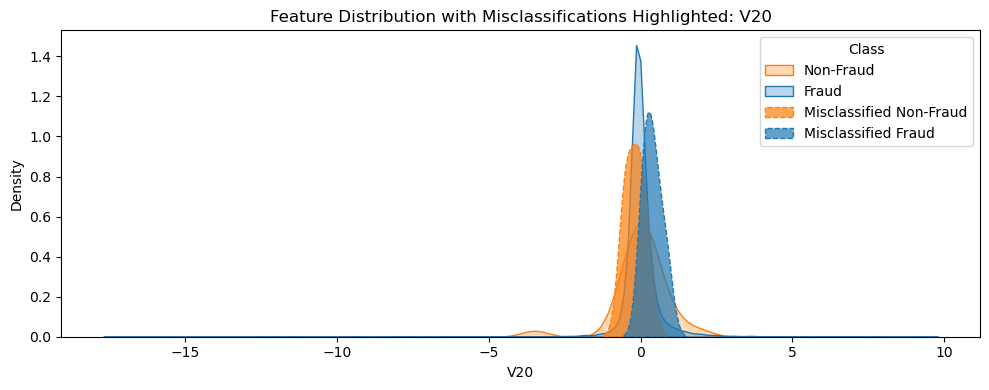

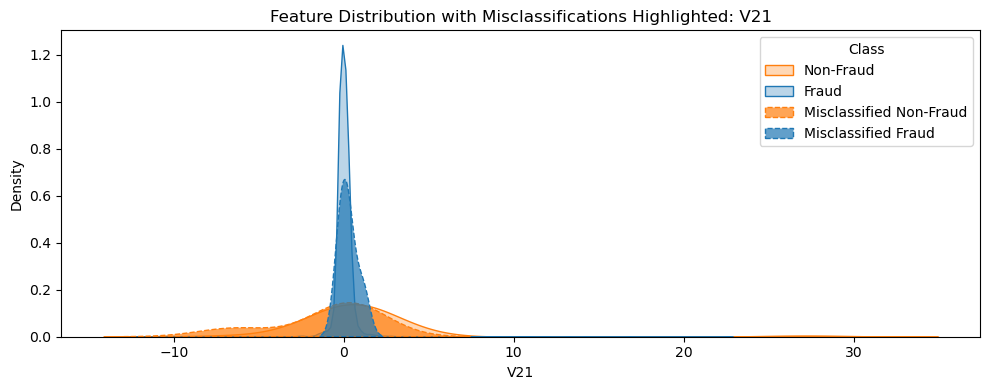

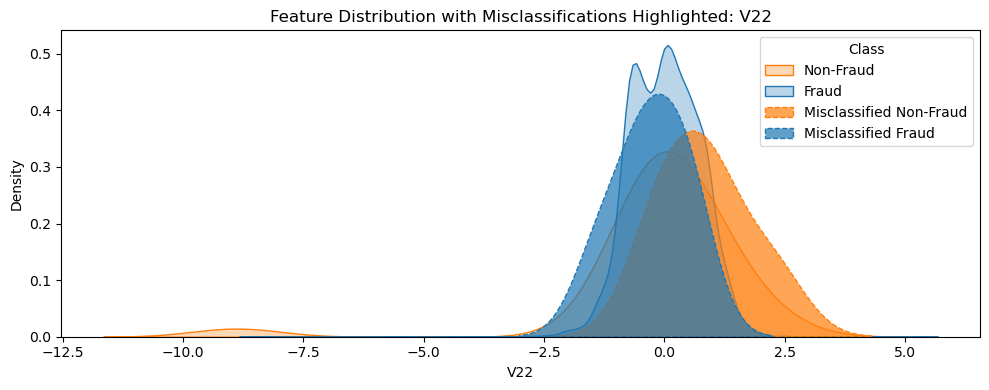

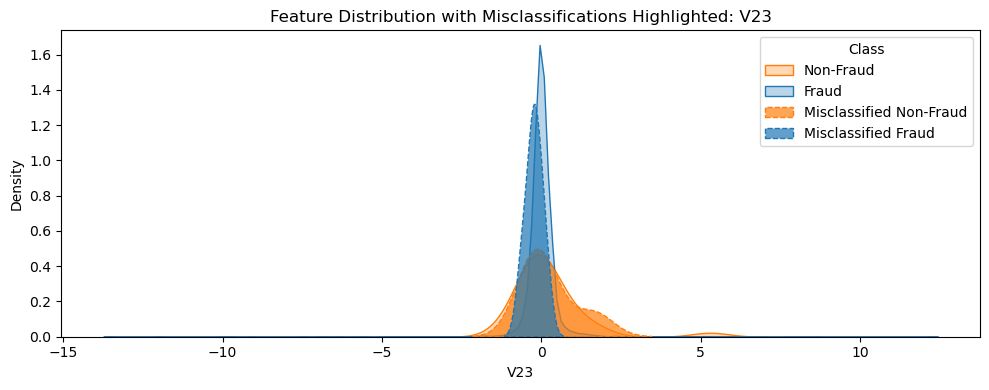

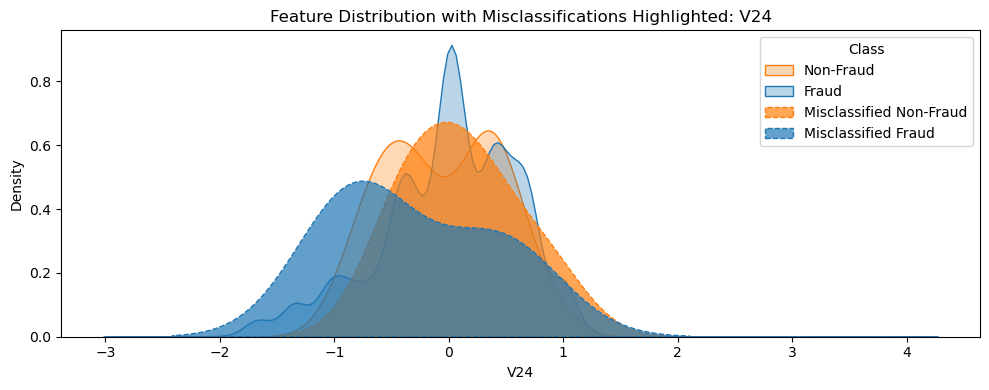

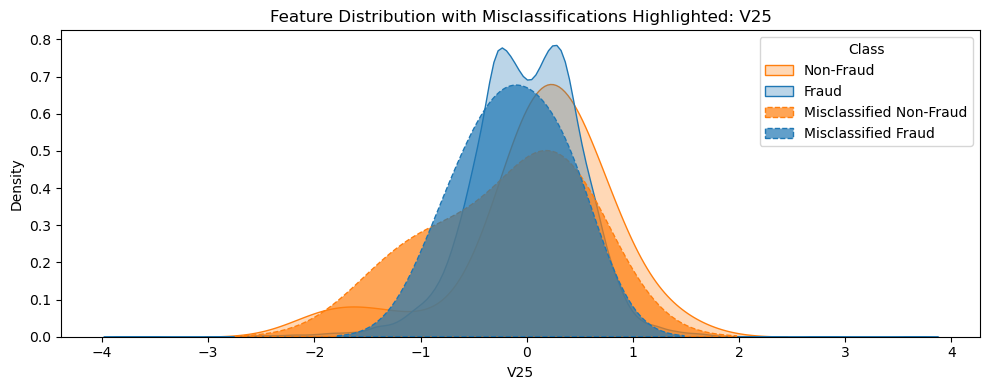

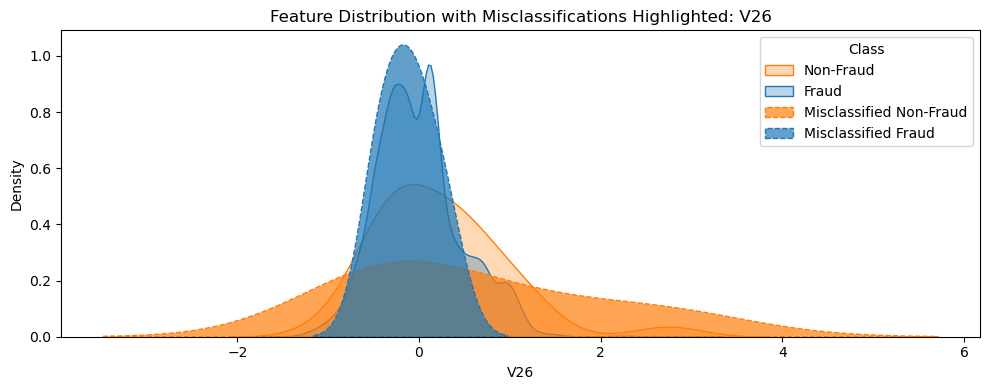

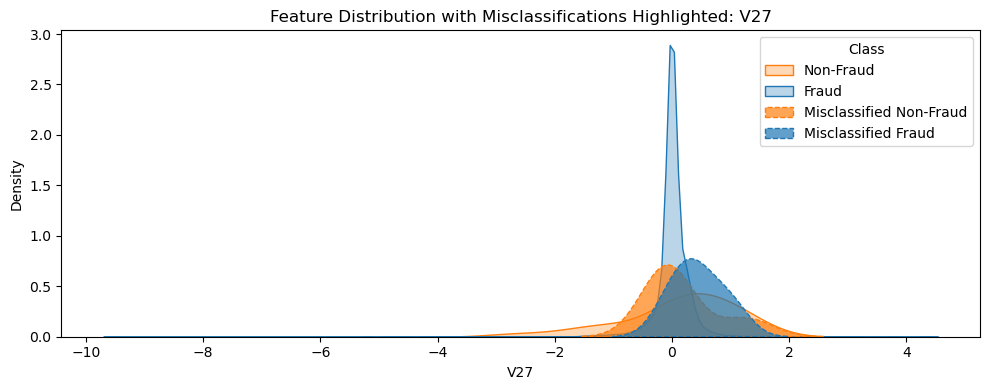

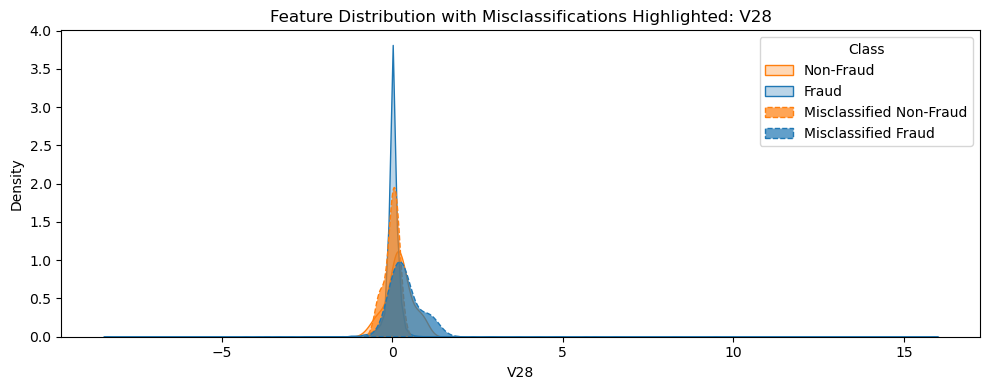

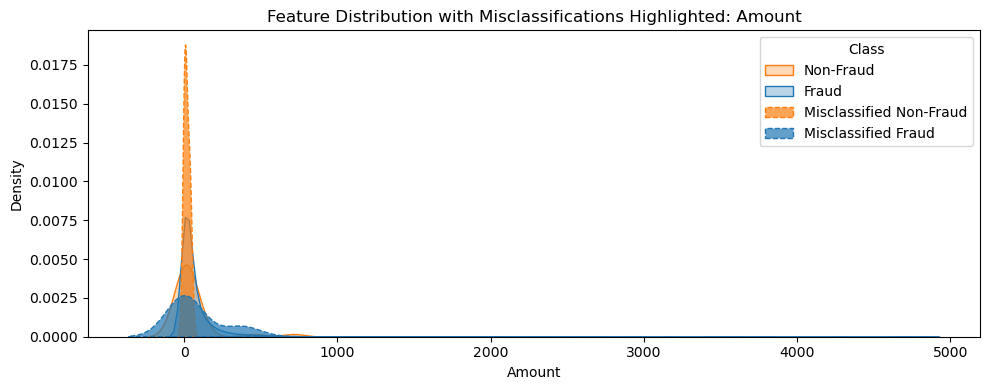

In [18]:
# Error Analysis Visualizations to identify patterns in misclassifications

# Error correlation with features
errors = X_test[y_test != y_pred_bayes]
errors['Actual'] = y_test[y_test != y_pred_bayes]
errors['Predicted'] = y_pred_bayes[y_test != y_pred_bayes]

# Plot feature distributions for misclassified samples
print("\nError Analysis - Misclassified Samples:")
for feature in feature_names:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(data=X_test, x=feature, hue=y_test, common_norm=False, fill=True, alpha=0.3)
    sns.kdeplot(data=errors, x=feature, hue=errors['Actual'], common_norm=False, fill=True, alpha=0.7, linestyle='--')
    plt.title(f'Feature Distribution with Misclassifications Highlighted: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend(title='Class', labels=['Non-Fraud', 'Fraud', 'Misclassified Non-Fraud', 'Misclassified Fraud'])
    plt.tight_layout()
    plt.show()


In [19]:
# Feature Engineering - Function-based (no custom class)
import numpy as np

def feature_engineering(X):
    X_fe = X.copy()
    # Log transformations
    X_fe['Amount_Log'] = np.log1p(X_fe['Amount'])
    X_fe['Time_Log'] = np.log1p(X_fe['Time'])
    # Add polynomial and interaction features for selected columns
    candidate_features = ['V14', 'V12', 'V10', 'V17', 'V11', 'V4', 'V16']
    for feature in candidate_features[:3]:
        if feature in X_fe.columns:
            X_fe[f'{feature}_squared'] = X_fe[feature] ** 2
    if len(candidate_features) >= 2:
        feat1 = candidate_features[0]
        feat2 = candidate_features[1]
        if feat1 in X_fe.columns and feat2 in X_fe.columns:
            X_fe[f'{feat1}_x_{feat2}'] = X_fe[feat1] * X_fe[feat2]
    return X_fe

In [20]:
# Improved model pipeline with function-based feature engineering
from sklearn.preprocessing import FunctionTransformer

X = X.copy()
y = y.copy()

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply feature engineering function to training and test data
X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)

# Get numeric features after feature engineering
numeric_features = X_train_fe.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nNumeric features after feature engineering: {len(numeric_features)} features")

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Logistic Regression Pipeline with FunctionTransformer
log_clf = Pipeline(steps=[
    ('feature_engineering', FunctionTransformer(feature_engineering)),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Random Forest Pipeline with FunctionTransformer
rf_clf = Pipeline(steps=[
    ('feature_engineering', FunctionTransformer(feature_engineering)),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# XGBoost Pipeline with FunctionTransformer
xb_clf = Pipeline(steps=[
    ('feature_engineering', FunctionTransformer(feature_engineering)),
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, n_jobs=1))
])

# Create Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('logistic', log_clf),
    ('random_forest', rf_clf),
    ('xgboost', xb_clf)
], voting='soft')


Numeric features after feature engineering: 36 features


In [21]:
# Hyperparameter tuning and evaluation (function-based pipeline)

# RandomizedSearch parameter grid
param_dist_random = {
    'logistic__classifier__C': uniform(0.1, 5),
    'logistic__classifier__class_weight': ['balanced', {0: 1, 1: 20}],
    'random_forest__classifier__n_estimators': randint(50, 150),
    'random_forest__classifier__class_weight': ['balanced', 'balanced_subsample'],
    'xgboost__classifier__n_estimators': randint(50, 150),
    'xgboost__classifier__max_depth': randint(3, 7),
    'xgboost__classifier__learning_rate': uniform(0.05, 0.2),
    'xgboost__classifier__scale_pos_weight': [25, 50, 75]
}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# RandomizedSearch - broad exploration
random_search = RandomizedSearchCV(
    estimator=voting_clf,
    param_distributions=param_dist_random,
    n_iter=10,
    scoring='recall',
    cv=skf,
    n_jobs=-1,
    random_state=42
)

print("Running RandomizedSearch...")
random_search.fit(X_train, y_train)

best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)
y_proba_random = best_model_random.predict_proba(X_test)[:, 1]

report_random = classification_report(y_test, y_pred_random, output_dict=True)
recall_random = report_random['1']['recall']
f1_random = report_random['1']['f1-score']
precision_random = report_random['1']['precision']

print(f"\nRandomizedSearch Results:")
print(f"Recall: {recall_random:.4f} | F1: {f1_random:.4f} | Precision: {precision_random:.4f}")
print(f"Best params: {random_search.best_params_}")

# BayesianSearch and final evaluation would follow similarly as before

best_params = random_search.best_params_

# Extract best values
best_C = best_params.get('logistic__classifier__C', 1.0)
best_rf_n_est = best_params.get('random_forest__classifier__n_estimators', 100)
best_xgb_n_est = best_params.get('xgboost__classifier__n_estimators', 100)
best_xgb_depth = best_params.get('xgboost__classifier__max_depth', 5)
best_xgb_lr = best_params.get('xgboost__classifier__learning_rate', 0.1)
best_scale_pos = best_params.get('xgboost__classifier__scale_pos_weight', 50)

# Build narrow ranges around best parameters
bayesian_param_dist = {
    'logistic__classifier__C': Real(max(0.01, best_C * 0.5), min(10, best_C * 2), prior='log-uniform'),
    'logistic__classifier__class_weight': Categorical(['balanced']),
    'random_forest__classifier__n_estimators': Integer(max(50, best_rf_n_est - 30), min(200, best_rf_n_est + 30)),
    'random_forest__classifier__class_weight': Categorical(['balanced', 'balanced_subsample']),
    'xgboost__classifier__n_estimators': Integer(max(50, best_xgb_n_est - 30), min(200, best_xgb_n_est + 30)),
    'xgboost__classifier__max_depth': Integer(max(2, best_xgb_depth - 2), min(10, best_xgb_depth + 2)),
    'xgboost__classifier__learning_rate': Real(max(0.01, best_xgb_lr * 0.5), min(0.3, best_xgb_lr * 2), prior='log-uniform'),
    'xgboost__classifier__scale_pos_weight': Integer(max(20, best_scale_pos - 25), min(150, best_scale_pos + 25))
}

bayes_search = BayesSearchCV(
    estimator=voting_clf,
    search_spaces=bayesian_param_dist,
    n_iter=15,
    scoring='recall',
    cv=skf,
    n_jobs=-1,
    random_state=42
)

print("\nRunning Bayesian Optimization...")
bayes_search.fit(X_train, y_train)

best_model_bayes = bayes_search.best_estimator_
y_pred_bayes = best_model_bayes.predict(X_test)
y_proba_bayes = best_model_bayes.predict_proba(X_test)[:, 1]

report_bayes = classification_report(y_test, y_pred_bayes, output_dict=True)
recall_bayes = report_bayes['1']['recall']
f1_bayes = report_bayes['1']['f1-score']
precision_bayes = report_bayes['1']['precision']

# Final Comparison
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"{'Metric':<15} {'Random':<12} {'Bayesian':<12} {'Δ':<10}")
print("-"*50)
print(f"{'Recall':<15} {recall_random:<12.4f} {recall_bayes:<12.4f} {recall_bayes-recall_random:+.4f}")
print(f"{'F1-Score':<15} {f1_random:<12.4f} {f1_bayes:<12.4f} {f1_bayes-f1_random:+.4f}")
print(f"{'Precision':<15} {precision_random:<12.4f} {precision_bayes:<12.4f} {precision_bayes-precision_random:+.4f}")
print("="*50)

print("\nConfusion Matrix (Bayesian):")
print(confusion_matrix(y_test, y_pred_bayes))
print("\nClassification Report (Bayesian):")
print(classification_report(y_test, y_pred_bayes))


Running RandomizedSearch...

RandomizedSearch Results:
Recall: 0.8571 | F1: 0.7534 | Precision: 0.6720
Best params: {'logistic__classifier__C': 0.3322520635999886, 'logistic__classifier__class_weight': 'balanced', 'random_forest__classifier__class_weight': 'balanced', 'random_forest__classifier__n_estimators': 70, 'xgboost__classifier__learning_rate': 0.1400998503939086, 'xgboost__classifier__max_depth': 4, 'xgboost__classifier__n_estimators': 53, 'xgboost__classifier__scale_pos_weight': 25}

Running Bayesian Optimization...

RandomizedSearch Results:
Recall: 0.8571 | F1: 0.7534 | Precision: 0.6720
Best params: {'logistic__classifier__C': 0.3322520635999886, 'logistic__classifier__class_weight': 'balanced', 'random_forest__classifier__class_weight': 'balanced', 'random_forest__classifier__n_estimators': 70, 'xgboost__classifier__learning_rate': 0.1400998503939086, 'xgboost__classifier__max_depth': 4, 'xgboost__classifier__n_estimators': 53, 'xgboost__classifier__scale_pos_weight': 25}


/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2


FINAL RESULTS
Metric          Random       Bayesian     Δ         
--------------------------------------------------
Recall          0.8571       0.8776       +0.0204
F1-Score        0.7534       0.7227       -0.0307
Precision       0.6720       0.6143       -0.0577

Confusion Matrix (Bayesian):
[[56810    54]
 [   12    86]]

Classification Report (Bayesian):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.61      0.88      0.72        98

    accuracy                           1.00     56962
   macro avg       0.81      0.94      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [22]:
# Model Serialization and Versioning (function-based pipeline)
import joblib
import json
from pathlib import Path
from datetime import datetime

# Create models directory
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

def save_model(model, name, metrics, params, description=''):
    """
    Save model with metadata in a simple, organized way.
    
    Parameters:
    -----------
    model : trained model
    name : str (e.g., 'voting_random' or 'voting_bayesian')
    metrics : dict with recall, f1, precision
    params : dict of hyperparameters
    description : str
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save model
    model_file = models_dir / f'{name}_{timestamp}.pkl'
    joblib.dump(model, model_file, compress=3)
    
    # Save metadata alongside
    metadata = {
        'name': name,
        'timestamp': timestamp,
        'metrics': metrics,
        'hyperparameters': params,
        'description': description,
        'model_file': str(model_file)
    }
    
    metadata_file = models_dir / f'{name}_{timestamp}_info.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f" Saved: {name}")
    print(f"  Model: {model_file.name}")
    print(f"  Metrics: Recall={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")
    
    return str(model_file)

def list_saved_models():
    """List all saved models."""
    model_files = sorted(models_dir.glob('*.pkl'))
    
    if not model_files:
        print("No saved models found.")
        return
    
    print("\n" + "="*60)
    print("SAVED MODELS")
    print("="*60)
    
    for model_file in model_files:
        info_file = str(model_file).replace('.pkl', '_info.json')
        if Path(info_file).exists():
            with open(info_file, 'r') as f:
                info = json.load(f)
            print(f"\n{info['name']} ({info['timestamp']})")
            print(f"  Recall: {info['metrics']['recall']:.4f}")
            print(f"  F1: {info['metrics']['f1']:.4f}")
            print(f"  Precision: {info['metrics']['precision']:.4f}")
            print(f"  Description: {info['description']}")
        else:
            print(f"\n{model_file.name} (no metadata)")
    print("="*60)

# Save RandomizedSearch model
save_model(
    model=best_model_random,
    name='voting_random',
    metrics={'recall': recall_random, 'f1': f1_random, 'precision': precision_random},
    params=random_search.best_params_,
    description='Voting classifier with RandomizedSearch (function-based pipeline)'
)

# Save Bayesian model
save_model(
    model=best_model_bayes,
    name='voting_bayesian',
    metrics={'recall': recall_bayes, 'f1': f1_bayes, 'precision': precision_bayes},
    params=bayes_search.best_params_,
    description='Voting classifier with Bayesian optimization (function-based pipeline)'
)

# List all saved models
list_saved_models()

 Saved: voting_random
  Model: voting_random_20251207_220624.pkl
  Metrics: Recall=0.8571, F1=0.7534
 Saved: voting_bayesian
  Model: voting_bayesian_20251207_220624.pkl
  Metrics: Recall=0.8776, F1=0.7227

SAVED MODELS

voting_bayesian (20251207_220624)
  Recall: 0.8776
  F1: 0.7227
  Precision: 0.6143
  Description: Voting classifier with Bayesian optimization (function-based pipeline)

voting_random (20251207_220624)
  Recall: 0.8571
  F1: 0.7534
  Precision: 0.6720
  Description: Voting classifier with RandomizedSearch (function-based pipeline)
 Saved: voting_bayesian
  Model: voting_bayesian_20251207_220624.pkl
  Metrics: Recall=0.8776, F1=0.7227

SAVED MODELS

voting_bayesian (20251207_220624)
  Recall: 0.8776
  F1: 0.7227
  Precision: 0.6143
  Description: Voting classifier with Bayesian optimization (function-based pipeline)

voting_random (20251207_220624)
  Recall: 0.8571
  F1: 0.7534
  Precision: 0.6720
  Description: Voting classifier with RandomizedSearch (function-based p